In [0]:
import pandas as pd
import os
from tqdm import tqdm

In [0]:
from aggregated_features import agg_features
from mcc2vec import person2vec, mcc_dt_agg
from time_features import mu_std_calculation, is_in_interval, calculate_hours, calculate_periodic_mean, calculate_periodic_std

In [3]:
!pip install pyarrow==0.16

Loading transcton data

Calculating some statistics

In [0]:
path_root_trans = "/content/drive/My Drive/antifraud/trans_april_may_st0_el_history_card_repart_anon"

In [0]:
files_1 = os.listdir(path_root_trans)
files_1.sort()

In [0]:
tr_data = pd.DataFrame()

In [8]:
for i,f in tqdm(enumerate(files_1[1:])):
  tr_data = pd.read_parquet(os.path.join(path_root_trans, f))
  agg_data = agg_features(tr_data)
  agg_data.to_csv("/content/drive/My Drive/antifraud/agg/agg_features {}.csv".format(str(i)))

101it [20:25, 12.14s/it]


In [9]:
agg_data.head()

,event_type count CARD_PIN_CHANGE,event_type count CLIENT_DEFINED,event_type count DEPOSIT,event_type count PAYMENT,event_type count UPDATE_USER,event_type count VIEW_STATEMENT,event_type count WITHDRAW,event_type mean CARD_PIN_CHANGE,event_type mean CLIENT_DEFINED,event_type mean DEPOSIT,event_type mean PAYMENT,event_type mean UPDATE_USER,event_type mean VIEW_STATEMENT,event_type mean WITHDRAW,event_type count CARD_PIN_CHANGE distr,event_type count CLIENT_DEFINED distr,event_type count DEPOSIT distr,event_type count PAYMENT distr,event_type count UPDATE_USER distr,event_type count VIEW_STATEMENT distr,event_type count WITHDRAW distr,event_type mean CARD_PIN_CHANGE distr,event_type mean CLIENT_DEFINED distr,event_type mean DEPOSIT distr,event_type mean PAYMENT distr,event_type mean UPDATE_USER distr,event_type mean VIEW_STATEMENT distr,event_type mean WITHDRAW distr,user_defined_event_type count ATM_BALANCE,user_defined_event_type count ATM_CASH,user_defined_event_type count ATM_CASH_CHECK,user_defined_event_type count ATM_EDITAUTOPAYMENT,user_defined_event_type count ATM_MINI_ST,user_defined_event_type count ATM_P2P_CHECK,user_defined_event_type count ATM_P2P_CREDIT,user_defined_event_type count ATM_P2P_DEBIT,user_defined_event_type count ATM_PAYMENT,user_defined_event_type count ATM_PHONE,user_defined_event_type count ATM_PIN,user_defined_event_type count ATM_RECEIPT,...,mcc_group count T,mcc_group count U,mcc_group count X,mcc_group count Z,mcc_group mean A,mcc_group mean C,mcc_group mean F,mcc_group mean H,mcc_group mean J,mcc_group mean O,mcc_group mean Q,mcc_group mean R,mcc_group mean T,mcc_group mean U,mcc_group mean X,mcc_group mean Z,mcc_group count A distr,mcc_group count C distr,mcc_group count F distr,mcc_group count H distr,mcc_group count J distr,mcc_group count O distr,mcc_group count Q distr,mcc_group count R distr,mcc_group count T distr,mcc_group count U distr,mcc_group count X distr,mcc_group count Z distr,mcc_group mean A distr,mcc_group mean C distr,mcc_group mean F distr,mcc_group mean H distr,mcc_group mean J distr,mcc_group mean O distr,mcc_group mean Q distr,mcc_group mean R distr,mcc_group mean T distr,mcc_group mean U distr,mcc_group mean X distr,mcc_group mean Z distr
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100055879,0,0,4,6,0,0,0,0.0,0.0,66555.000000,35533.333333,0.0,0.0,0.000000,0.0,0.000000,0.400000,0.600000,0.0,0.000000,0.000000,0.0,0.0,0.651935,0.348065,0.0,0.000000,0.000000,0,0,0,0,0,0,4,5,1,0,0,0,...,0,5,0,0,0.0,66555.000000,0.000000,0.0,0.0,0.0,0.0,1000.000000,0.0,42440.000000,0.0,0.000000,0.0,0.400000,0.000000,0.00000,0.0,0.0,0.000000,0.100000,0.000000,0.500000,0.000000,0.000000,0.0,0.605073,0.000000,0.000000,0.0,0.0,0.000000,0.009091,0.000000,0.385836,0.000000,0.000000
100061768,0,0,33,62,0,5,9,0.0,0.0,2310.213939,540.653710,0.0,0.0,4450.000000,0.0,0.000000,0.302752,0.568807,0.0,0.045872,0.082569,0.0,0.0,0.316430,0.074053,0.0,0.000000,0.609517,5,9,9,0,0,0,15,15,6,0,0,0,...,0,15,0,32,0.0,4664.466154,490.000000,0.0,0.0,0.0,0.0,380.523659,0.0,1172.604000,0.0,1626.843750,0.0,0.119266,0.073394,0.00000,0.0,0.0,0.000000,0.376147,0.000000,0.137615,0.000000,0.293578,0.0,0.559662,0.058792,0.000000,0.0,0.0,0.000000,0.045657,0.000000,0.140694,0.000000,0.195195
100065250,0,0,42,106,0,3,36,0.0,0.0,41586.857143,14199.639151,0.0,0.0,42250.000000,0.0,0.000000,0.224599,0.566845,0.0,0.016043,0.192513,0.0,0.0,0.424198,0.144840,0.0,0.000000,0.430962,3,1,1,0,0,0,40,56,27,0,0,0,...,3,56,0,40,0.0,43641.175000,0.000000,0.0,0.0,0.0,4000.0,524.058511,2802.0,26287.946429,0.0,37950.025000,0.0,0.213904,0.000000,0.00000,0.0,0.0,0.005348,0.251337,0.016043,0.299465,0.000000,0.213904,0.0,0.378813,0.000000,0.000000,0.0,0.0,0.034721,0.004549,0.024322,0.228184,0.000000,0.329412
100067271,0,0,113,332,0,0,18,0.0,0.0,24363.778761,9328.803193,0.0,0.0,42761.111111,0.0,0.000000,0.244060,0.717063,0.0,0.000000,0.038877,0.0,0.0,0.318674,0.122019,0.0,0.000000,0.559307,0,7,7,0,0,0,99,125

In [0]:
files_2 = os.listdir('/content/drive/My Drive/antifraud')
files_2 = [f for f in files_2 if f[-3:] == 'csv']

In [0]:
for i, f in enumerate(files_2):
  tr_data = pd.read_csv(os.path.join('/content/drive/My Drive/antifraud', f))
  tr_data = mu_std_calculation(tr_data)
  tr_data.to_csv("/content/drive/My Drive/antifraud/agg/time_features {}.csv".format(str(i)))

/content/time_features.py:75: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(np.log(1/(np.power(sin, 2)+np.power(cos, 2))))


Loading targets for persons

In [0]:
path_root_agg = "/content/drive/My Drive/antifraud/trans_april_may_st3_agg"

In [0]:
tr_data = pd.DataFrame()

In [0]:
files = os.listdir(path_root_agg)
files.sort()

In [0]:
for f in tqdm(files[1:]):
  tr_data = tr_data.append(pd.read_parquet(os.path.join(path_root_agg, f)))

100%|██████████| 200/200 [07:58<00:00,  2.39s/it]


In [0]:
path_root_trans = "/content/drive/My Drive/antifraud/trans_april_may_st0_markup_incoming_transactions_anon"

In [0]:
data_trans = pd.DataFrame()

In [0]:
files = os.listdir(path_root_trans)
files.sort()

In [0]:
files

['_SUCCESS',
 'part-00000-bb6611c7-f26e-48ad-a37d-f13d9d7e4749-c000.snappy.parquet',
 'part-00001-bb6611c7-f26e-48ad-a37d-f13d9d7e4749-c000.snappy.parquet',
 'part-00002-bb6611c7-f26e-48ad-a37d-f13d9d7e4749-c000.snappy.parquet',
 'part-00003-bb6611c7-f26e-48ad-a37d-f13d9d7e4749-c000.snappy.parquet',
 'part-00004-bb6611c7-f26e-48ad-a37d-f13d9d7e4749-c000.snappy.parquet',
 'part-00005-bb6611c7-f26e-48ad-a37d-f13d9d7e4749-c000.snappy.parquet',
 'part-00006-bb6611c7-f26e-48ad-a37d-f13d9d7e4749-c000.snappy.parquet']

In [0]:
for f in tqdm(files[1:]):
  data_trans = data_trans.append(pd.read_parquet(os.path.join(path_root_trans, f)))

100%|██████████| 7/7 [00:00<00:00, 20.56it/s]


In [0]:
data_trans

,event_id,user_id,user_id_rcvr,policy_action,risk_score,amount_original,event_time_
0,83cfb3a65bd943f18c4da6dc653ccf68,1870825,5540217,REVIEW,684,120000,1.554394e+09
1,a9cc86a4e52a4d898e6f593f50515be0,23465860,26903133,REVIEW,967,16000,1.554463e+09
2,b855e9868024450593239d34d4610513,MBK9395053,MBK9836211,REVIEW,994,10000,1.554536e+09
3,4514599aa3f54aa497311dc9289dfd2d,37570001,37140634,REVIEW,733,340000,1.554549e+09
4,63592180fc8b4a55a3c0fa12d0f79fa4,29705334,53214797,REVIEW,977,10000,1.554810e+09
...,...,...,...,...,...,...,...
14362,fb661f33d21f471fa936599cedbd47ab,49194968,11585469,REVIEW,536,15000,1.555313e+09
14363,d747ed5790554244b2f65972fd5c0059,2026042,22818226,REVIEW,650,8000,1.555915e+09
14364,6bb49760d44c48bfbbfc5378e5167da6,MBK5632283,19364183,REVIEW,644,25000,1.554291e+09
14365,f3d48a2d15c14effb267678b16eba53d,28570186,59430976,REVIEW,796,179000,1.556518e+09


In [0]:
ids1 = set(tr_data.event_id)

In [0]:
ids2 = set(data_trans.event_id)

In [0]:
target_ids = ids1.intersection(ids2)

In [0]:
len(target_ids)

223224

In [0]:
target = tr_data[tr_data.event_id.isin(target_ids)][["event_id", "USER_ID",	"USER_ID_RCVR",	"CLASS"]]

Разделим на треин и тест чтобы пересечения по клиентам не было

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
def tr_tst_split(tr):
    genue = tr[tr.CLASS == 0].sort_values("USER_ID_RCVR")
    fraud = tr[tr.CLASS == 1].sort_values("USER_ID_RCVR")
    
    fraud_tr, fraud_tst = train_test_split(fraud, test_size = 0.2, shuffle = False)
    genue_tr, genue_tst = train_test_split(genue, test_size = 0.2, shuffle = False)
    print(set(fraud_tr.USER_ID_RCVR).intersection(fraud_tst.USER_ID_RCVR))
    print(len(set(fraud_tr.USER_ID).intersection(fraud_tst.USER_ID)))
    
    return pd.concat([fraud_tr, genue_tr]), pd.concat([fraud_tst, genue_tst])

In [0]:
target_train, target_test = tr_tst_split(target)

set()
44


Посмотрим распределение по времени у мошенников и нормальных людей

In [0]:
def genue_fraud_mu_std(tr_hist, tr):
    genue = tr[tr.CLASS == 0][["USER_ID", "USER_ID_RCVR"]].values.ravel()
    fraud = tr[tr.CLASS == 1].USER_ID_RCVR
    
    fr_times = calculate_hours(tr_hist[tr_hist.user_id.isin(fraud)].event_time)
    gn_times = calculate_hours(tr_hist[tr_hist.user_id.isin(genue)].event_time)
    
    fr_mu = calculate_periodic_mean(fr_times)
    fr_std = calculate_periodic_std(fr_times)
    
    gn_mu = calculate_periodic_mean(gn_times)
    gn_std = calculate_periodic_std(gn_times)
    
    return [fr_mu, fr_std, gn_mu, gn_std]

In [0]:
time_data = pd.DataFrame()

In [0]:
for i, f in enumerate(files_2):
  time_data = pd.concat((time_data, pd.read_csv(os.path.join('/content/drive/My Drive/antifraud', f))))

In [0]:
time_data

,Unnamed: 0,user_id,event_time,atm_mcc
0,0,91970740,1550251213000,6011.0
1,1,43335883,1549910159000,5411.0
2,2,MBK5659333,1556169012000,6010.0
3,3,31705480,1550579547000,6010.0
4,4,18469968,1550582802000,5411.0
...,...,...,...,...
4852605,1201457,5459417,1551010433000,5814.0
4852606,1201458,MBK13268567,1549415344000,6011.0
4852607,1201459,50396314,1551387178000,6010.0
4852608,1201460,41320573,1551100607000,6011.0


In [0]:
fr_mu, fr_std, gn_mu, gn_std = genue_fraud_mu_std(time_data, target_test)

Посчитаем попадания в доверительные интервалы

In [0]:
from scipy.stats import vonmises_line

vonmises_fr = vonmises_line(kappa = 1/fr_std, loc= fr_mu)
interval_fr = vonmises_fr.interval(0.8)
l_fr = interval_fr[0]
r_fr = interval_fr[1]

if l_fr>r_fr: l_fr, r_fr = r_fr, l_fr

vonmises_gn = vonmises_line(kappa = 1/gn_std, loc= gn_mu)
interval_gn = vonmises_gn.interval(0.8)
l_gn = interval_gn[0]
r_gn = interval_gn[1]

if l_gn>r_gn: l_gn, r_gn = r_gn, l_gn

In [0]:
intervals_fr = time_data.groupby("user_id").event_time.agg(lambda x: is_in_interval(l_fr, r_fr, x))

intervals_gn = time_data.groupby("user_id").event_time.agg(lambda x: is_in_interval(l_gn, r_gn, x))

In [0]:
intervals = pd.concat([intervals_fr, intervals_gn], axis =1)
intervals.columns = ["fraud interval", "genue interval"]

In [0]:
intervals

,fraud interval,genue interval
user_id,,
10000005,0.229391,0.265233
100000436,0.509434,0.594340
100000736,0.735409,0.797665
100000741,0.500000,1.000000
100000799,0.679012,0.734568
...,...,...
VSP9970837,1.000000,1.000000
VSP9970855,0.921053,0.885965
VSP9970871,0.920732,0.884146


In [0]:
intervals.to_csv("/content/drive/My Drive/antifraud/agg/intervals.csv")

Посчитаем какую часть переводов клиент делаем сам, а какую получает

In [0]:
 pd.concat([us_complited, rec_us_complited], axis =1)

In [0]:
def new

In [0]:
completed_trans = data_trans.groupby(["user_id", "event_id"])['amount_original'].agg(['sum','count'])\
    .groupby(level=0).cumsum()

In [0]:
get_trans = data_trans.groupby(["user_id_rcvr", "event_id"])['amount_original'].agg(['sum','count'])\
    .groupby(level=0).cumsum()

In [0]:
completed_trans.index = [ j for i, j in completed_trans.index]

In [0]:
get_trans.index = [ j for i, j in get_trans.index]

In [0]:
completed_trans = completed_trans.loc[get_trans.index]

In [0]:
count = pd.concat([get_trans, completed_trans], axis =1)
# count.columns = ["get_tr","get_amount", "completed_tr", "taked_amount"]
# count["ratio count"] = count.apply(lambda x: x.completed_tr/(x.completed_tr+x.get_tr), axis = 1)
# count["ratio amount"] = count.apply(lambda x: x.taked_amount/(x.get_amount+x.taked_amount), axis = 1)

In [0]:
count.to_csv("/content/drive/My Drive/antifraud/agg/count_features.csv")

person2vec

In [0]:
%time doc_vec = person2vec(time_data)

KeyboardInterrupt: ignored

In [0]:
%time model = Doc2Vec(documents, vector_size=50, window=5, min_count=1, workers=4)

CPU times: user 3h 46min 58s, sys: 1h 35min 4s, total: 5h 22min 3s
Wall time: 3h 37min 5s


In [0]:
doc_vec = pd.read_csv("/content/drive/My Drive/antifraud/agg/mcc_features.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
doc_vec.set_index("Unnamed: 0", inplace = True)

In [0]:
doc_vec.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000005,0.094212,0.074970,-0.092342,-0.033854,0.190133,0.173116,-0.252787,-0.341665,0.121836,0.206761,0.279306,-0.200487,-0.238467,0.223217,-0.021972,-0.202111,0.023558,0.032956,0.093282,0.013845,0.084736,0.083099,-0.159306,0.193964,-0.234162,0.092363,-0.365877,-0.207402,-0.049479,0.265875,0.191899,0.128123,0.173036,0.162564,0.142748,0.145887,0.129075,-0.326082,0.442629,-0.203147,-0.154402,-0.097558,-0.098955,-0.078201,-0.487449,-0.120499,0.263025,-0.097580,0.196277,-0.162907
100000436,-0.056289,-0.333261,0.043189,-0.114053,-0.148746,-0.018828,-0.035371,-0.309817,-0.182100,0.298278,0.109506,-0.029757,-0.037162,0.059918,-0.003830,-0.172359,0.029350,-0.038322,-0.033434,0.156084,-0.260857,0.078180,0.090832,-0.170872,-0.386493,0.392571,-0.111736,-0.035162,-0.174733,0.438784,0.216640,-0.010822,-0.154158,0.056118,0.083555,0.067532,0.199724,-0.097065,0.314107,-0.084748,-0.202675,0.066174,-0.063516,-0.141115,-0.254740,0.081565,0.261625,0.066766,-0.145219,-0.063180
100000736,-0.077203,-0.119751,-0.104929,-0.167173,-0.150799,0.118442,-0.139098,0.062963,-0.213130,0.043742,0.071224,-0.510502,-0.243186,0.021727,0.143354,-0.102528,0.145125,0.041925,0.106009,0.159540,-0.068458,0.111316,-0.215646,-0.098863,-0.269909,-0.153442,0.018061,-0.161009,-0.028591,0.188550,0.008096,0.072443,0.023579,0.182967,-0.007667,-0.011839,0.170856,-0.304365,0.389705,0.047941,0.007232,-0.272291,-0.126870,-0.127925,-0.396063,0.068378,0.112347,-0.137586,-0.170138,-0.222899
100000741,0.011991,-0.064618,0.023851,0.020584,-0.001286,0.087586,0.020214,-0.023006,0.141585,-0.027218,0.084920,-0.080790,-0.082522,-0.013127,-0.083263,0.026596,-0.012057,-0.075226,0.014972,-0.007161,-0.026189,0.081292,0.037997,0.038617,-0.192273,0.029545,-0.023768,0.012785,-0.079093,0.013032,0.063155,0.042723,0.000253,0.024133,0.016438,0.042406,-0.033383,-0.126252,0.091587,-0.034799,-0.007859,-0.075777,-0.010967,-0.002931,-0.017687,-0.032796,0.132634,0.034002,-0.045125,-0.022498
100000799,-0.296069,-0.045467,-0.134479,-0.078551,-0.007188,0.130225,0.256573,0.006823,-0.100731,-0.009222,0.162601,-0.220941,0.046830,-0.058022,0.127975,0.103831,-0.007353,-0.157084,-0.195965,0.062891,0.003281,0.030389,-0.275080,-0.308746,-0.359742,0.088200,-0.038888,-0.011415,-0.106791,0.227689,0.163188,0.234553,-0.197371,0.235491,0.122527,0.197834,0.248384,-0.407476,0.448506,0.059739,0.183782,0.024875,0.013322,-0.026945,-0.179338,0.140633,0.321410,0.040113,-0.020448,0.027969


In [0]:
import umap

In [0]:
reducer = umap.UMAP()

In [0]:
view = reducer.fit_transform(doc_vec)

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastma

In [0]:
import matplotlib.pyplot as plt

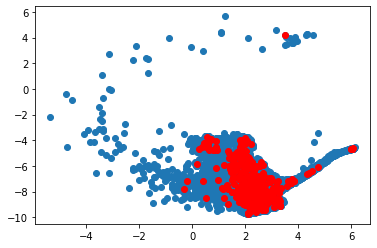

In [0]:
plt.scatter(view[:,0][doc_vec.index.isin(ids)], view[:,1][doc_vec.index.isin(ids)])
plt.scatter(view[:,0][doc_vec.index.isin(fr)], view[:,1][doc_vec.index.isin(fr)],c='r')

In [0]:
fr = tr_data[tr_data.CLASS==1].USER_ID_RCVR.unique()

In [0]:
doc_vec.index.isin(fr)

359

In [0]:
fr

4701

In [0]:
ids = target[["USER_ID", "USER_ID_RCVR"]].values.ravel()

In [0]:
doc_vec.index.isin(ids).sum()

29441

In [0]:
ids.sort()

TypeError: ignored